In [ ]:
import os
import sys

import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(123)


2022-02-20 19:24:06.775757: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Get data file DIODE data sets
Use validation set (smaller) as tranning set for now, to save computation time

In [3]:
# get data sets
annotation_folder = "/dataset/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

In [4]:
path = "val/indoors"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}
df = pd.DataFrame(data)

df = df.sample(frac=1, random_state=42)

In [5]:
HEIGHT = 256
WIDTH = 256
LR = 0.0002
EPOCHS = 30
BATCH_SIZE = 5

The pipeline takes a dataframe containing the path for the RGB images, as well as the depth and depth mask files.
It reads and resize the RGB images.
It reads the depth and depth mask files, process them to generate the depth map image and resize it.
It returns the RGB images and the depth map images for a batch.

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(768, 1024), n_channels=3, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_map, mask):
        """Load input and target image."""

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = np.load(depth_map).squeeze()

        mask = np.load(mask)
        mask = mask > 0

        max_depth = min(300, np.percentile(depth_map, 99))
        depth_map = np.clip(depth_map, self.min_depth, max_depth)
        depth_map = np.log(depth_map, where=mask)

        depth_map = np.ma.masked_where(~mask, depth_map)

        depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
        depth_map = cv2.resize(depth_map, self.dim)
        depth_map = np.expand_dims(depth_map, axis=2)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["image"][batch_id],
                self.data["depth"][batch_id],
                self.data["mask"][batch_id],
            )

        return x, y

# Visulization

2022-02-20 19:24:38.765787: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-20 19:24:38.768605: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-20 19:24:38.814815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 19:24:38.815213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-02-20 19:24:38.815235: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-20 19:24:38.844426: I tensorflow/stream_executor/platform/defa

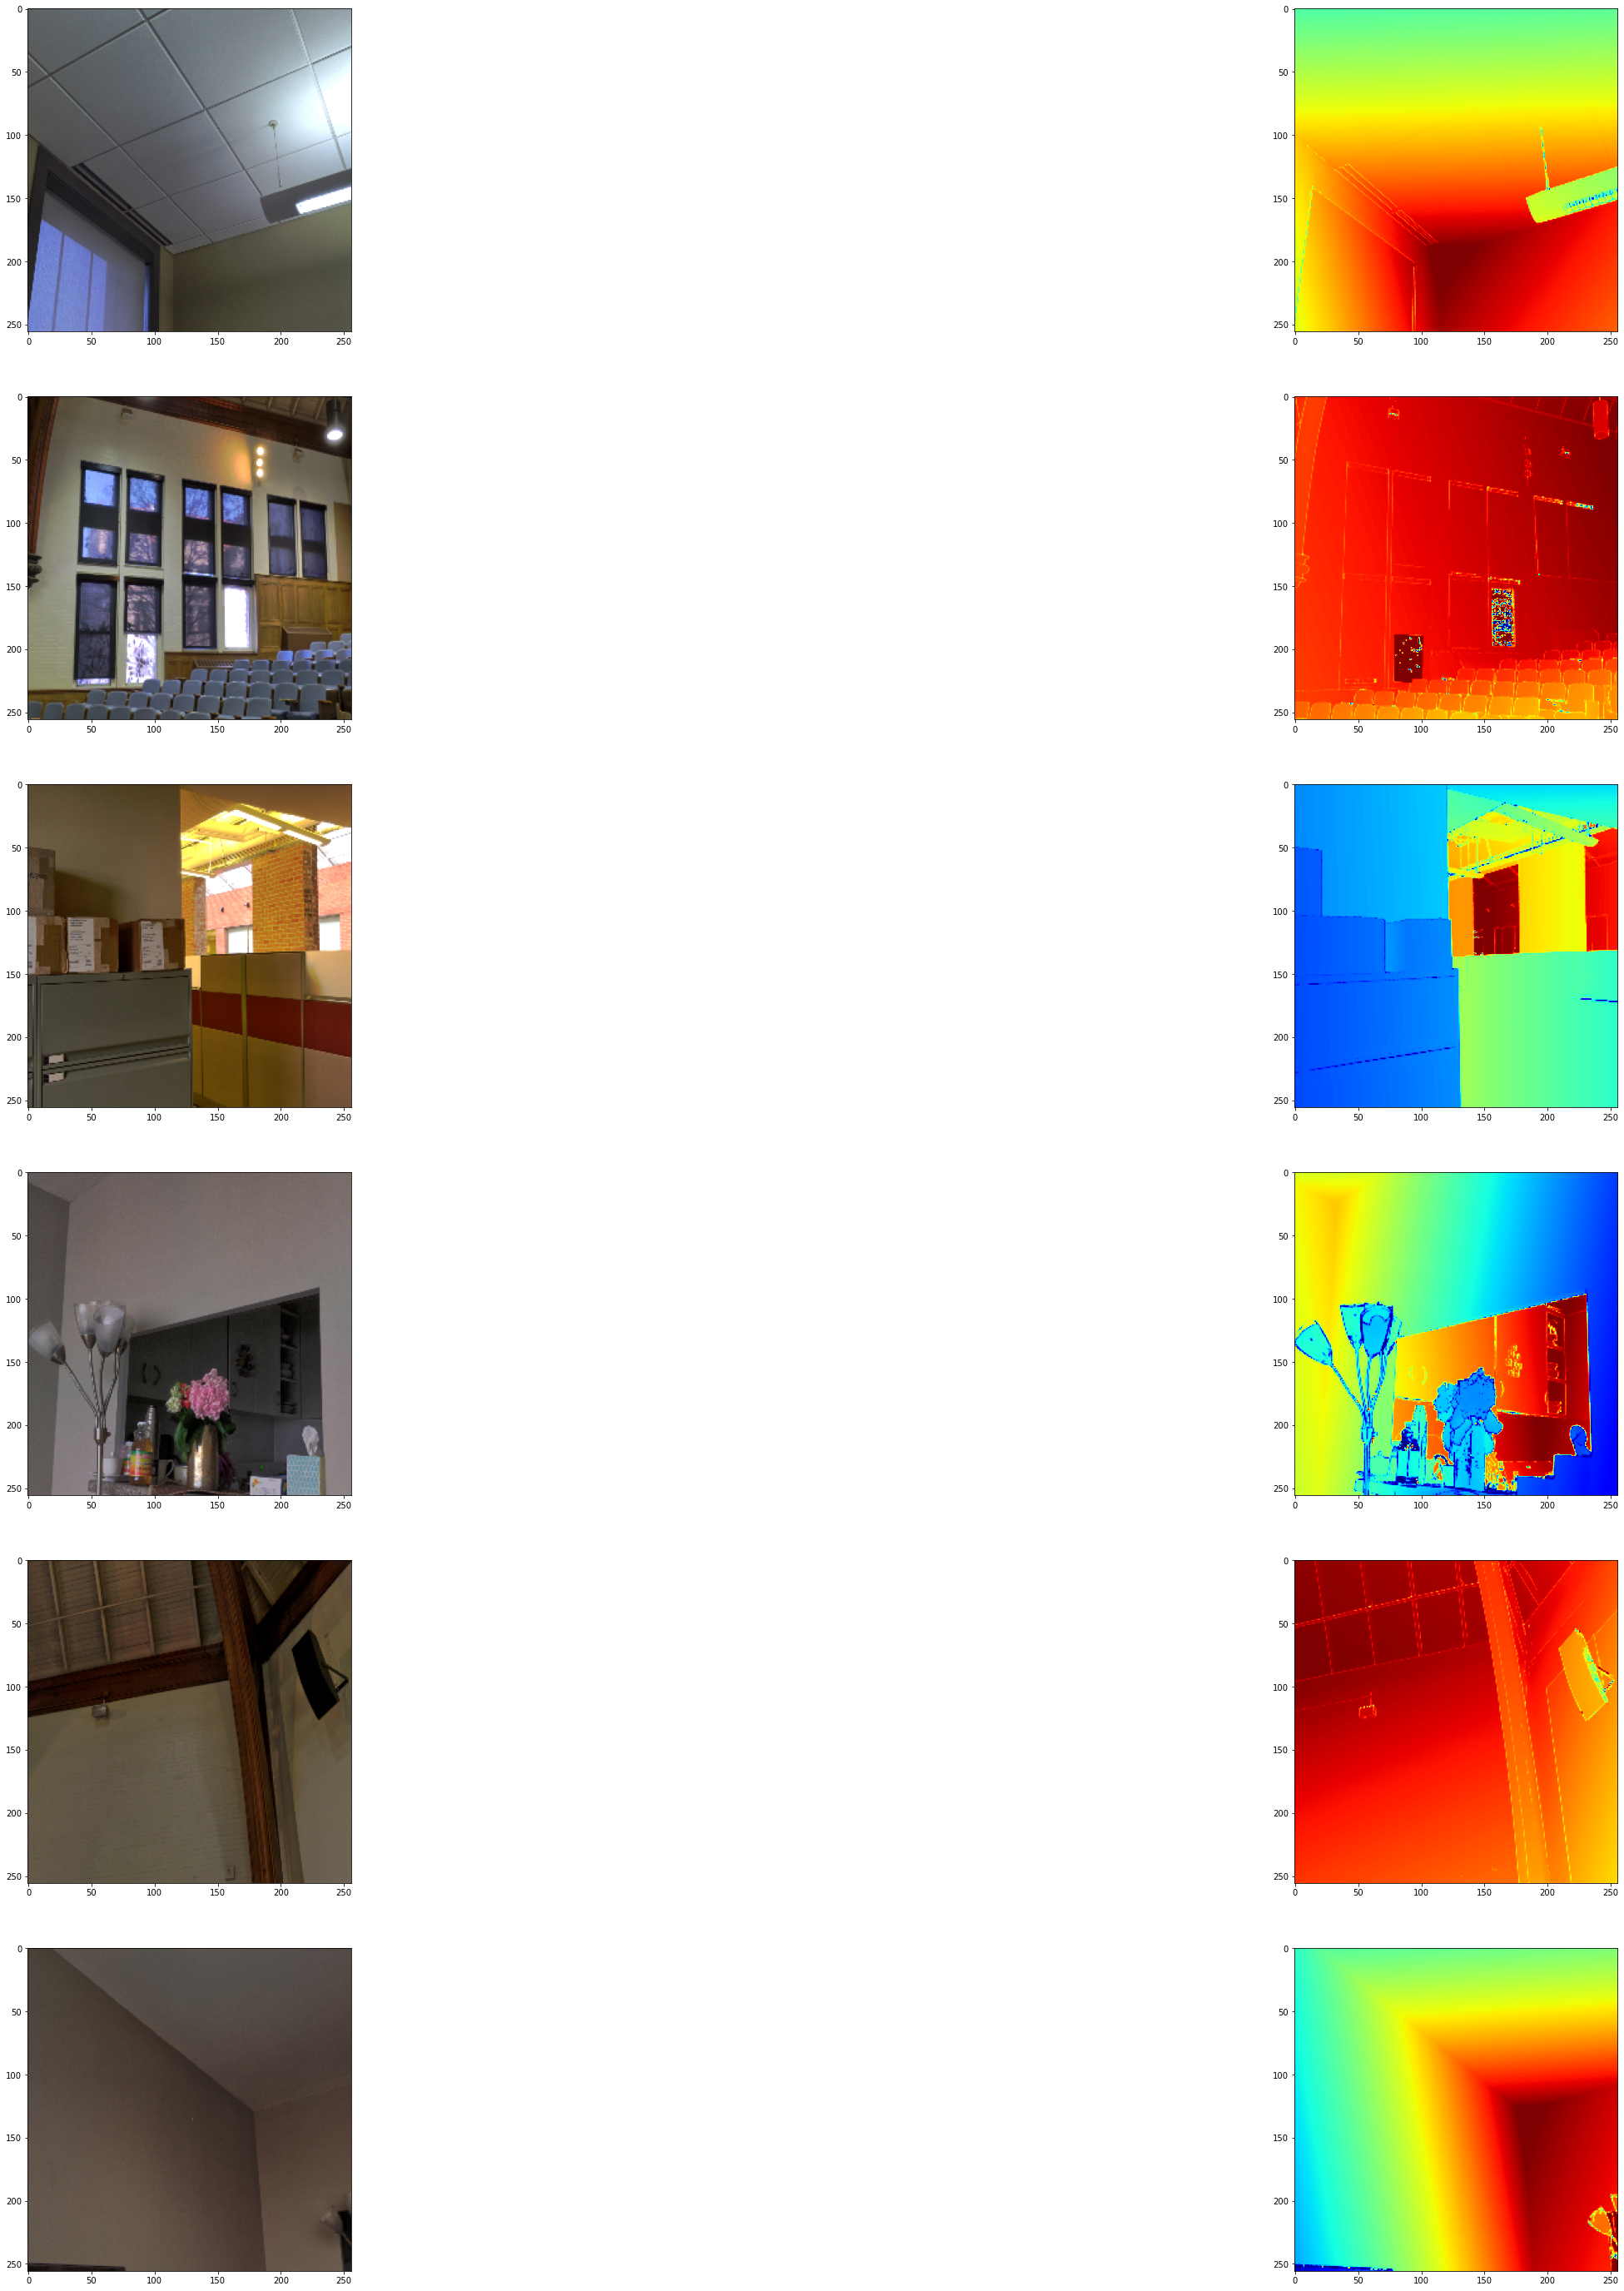

In [7]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)


visualize_samples = next(
    iter(DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH)))
)
visualize_depth_map(visualize_samples)


# Point cloud visulization

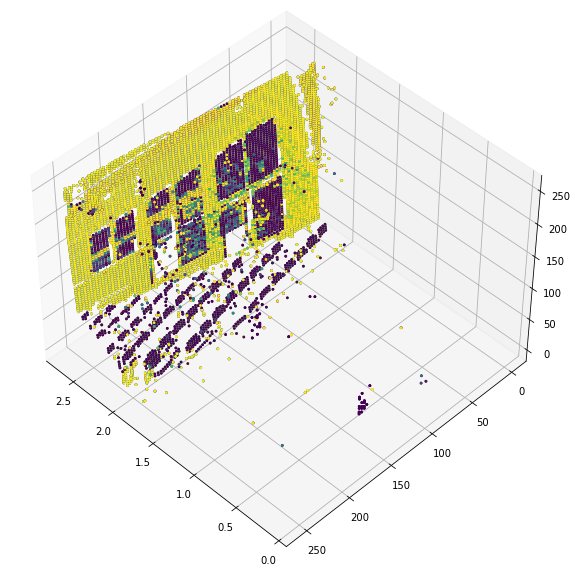

In [8]:
depth_vis = np.flipud(visualize_samples[1][1].squeeze())  # target
img_vis = np.flipud(visualize_samples[0][1].squeeze())  # input

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection="3d")

STEP = 3
for x in range(0, img_vis.shape[0], STEP):
    for y in range(0, img_vis.shape[1], STEP):
        ax.scatter(
            [depth_vis[x, y]] * 3,
            [y] * 3,
            [x] * 3,
            c=tuple(img_vis[x, y, :3] / 255),
            s=3,
        )
    ax.view_init(45, 135)

# Building the model
- The basic model is from U-Net.
- Addditive skip-connections are implemented in the downscaling block.


In [9]:
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x


# Defining the loss
We will optimize 3 losses in our mode. 1. Structural similarity index(SSIM). 2. L1-loss, or Point-wise depth in our case. 3. Depth smoothness loss.

Out of the three loss functions, SSIM contributes the most to improving model performance.

In [10]:
class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)

# Model training

In [13]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)
model = DepthEstimationModel()
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model.compile(optimizer, loss=cross_entropy)

train_loader = DataGenerator(
    data=df[:260].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_loader = DataGenerator(
    data=df[260:].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
model.fit(  
    train_loader,
    epochs=EPOCHS,
    validation_data=validation_loader,
)

2022-02-20 19:30:41.434438: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-02-20 19:30:41.443785: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

Visualizing model output

In [ ]:
test_loader = next(
    iter(
        DataGenerator(
            data=df[265:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

test_loader = next(
    iter(
        DataGenerator(
            data=df[300:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)